In [1]:
import os
import sys
from glob import glob

import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from scipy.signal import stft
from matplotlib import pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification
import torch.nn as nn
import torch.optim as optim

sys.path.append("../src")
from data import load_npy_file, convert_signal_to_complex

In [3]:
# Cell 2: Configuration
MODEL_CHECKPOINT = "facebook/vit-mae-huge"
IMAGE_DIR_TRAIN = '../data/RadioML/snr_20db/train/'
IMAGE_DIR_VAL = '../data/RadioML/snr_20db/test/'
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 5e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [4]:
# Cell 3: Custom Dataset
def get_color_img(spectrum_db: np.ndarray, colormap: str = 'viridis') -> np.ndarray:
    """Convert power spectrogram in dB to color image."""
    # Normalize the dB values to [0, 1] range for colormap
    norm_spectrum: np.ndarray = (spectrum_db - np.min(spectrum_db)) / (np.max(spectrum_db) - np.min(spectrum_db))
    
    # Apply colormap RGBA values ()
    rgba_img: np.ndarray = plt.get_cmap(colormap)(norm_spectrum)

    # Convert to RGB by removing the alpha channel
    alpha = rgba_img[..., 3:]       # shape (H, W, 1)
    rgb_channels = rgba_img[..., :3]     # shape (H, W, 3), floats in [0,1]
    bg_color = np.ones_like(rgb_channels)    # white background (1,1,1)

    # composite
    color_img = rgb_channels * alpha + bg_color * (1 - alpha)
    return color_img

def convert_to_pil(spectrum_db: np.ndarray, colormap='viridis') -> Image.Image:
    """Converts a spectrogram (numpy array) to a PIL Image."""
    rgb_image_np = get_color_img(spectrum_db=spectrum_db, colormap=colormap)
    rgb_image_uint8 = (rgb_image_np * 255).astype(np.uint8)
    pil_image = Image.fromarray(rgb_image_uint8, 'RGB')
    return pil_image

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, processor=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)
    
    def load_samples(self, idx):
        file_path = self.image_paths[idx]
        signal = load_npy_file(file_path)
        signal_data = convert_signal_to_complex(signal)
        colormap = 'viridis'  # Choose a colormap for visualization
        eps = 1e-12
        _,_, stft_matrix = stft(signal_data, nperseg=64, noverlap=32, window= 'hann', return_onesided=False)
        stft_matrix = np.fft.fftshift(stft_matrix, axes=0) 

        # Calculate power spectral density (magnitude squared)
        spectrum: np.ndarray = np.abs(stft_matrix) ** 2
        # Convert to dB for plotting
        spectrum_db: np.ndarray = 10 * np.log10(spectrum + eps)

        image = convert_to_pil(spectrum_db=spectrum_db, colormap=colormap)
        return image

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = self.load_samples(idx)
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Error: {e}")

        if self.transform:
            image = self.transform(image)

        if self.processor: # If using Hugging Face processor
            # The processor typically handles normalization and resizing.
            # Ensure your processor is configured correctly for your model.
            processed_inputs = self.processor(images=image, return_tensors="pt")
            image = processed_inputs['pixel_values'].squeeze(0) # Remove batch dim

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

def load_image_data(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                # Basic check for image files, can be more robust
                if img_path.lower().endswith(('.npy')):
                    image_paths.append(img_path)
                    labels.append(class_to_idx[class_name])
    return image_paths, labels, class_to_idx, idx_to_class

In [5]:
train_image_paths, train_labels, class_to_idx, idx_to_class = load_image_data(IMAGE_DIR_TRAIN)
val_image_paths, val_labels, _, _ = load_image_data(IMAGE_DIR_VAL) # Assuming same classes

print(f"Found {len(train_image_paths)} training images and {len(val_image_paths)} validation images.")
print(f"Classes: {class_to_idx}")
NUM_LABELS = len(class_to_idx)

Found 2400 training images and 240 validation images.
Classes: {'128APSK': 0, '128QAM': 1, '16APSK': 2, '16PSK': 3, '16QAM': 4, '256QAM': 5, '32APSK': 6, '32PSK': 7, '32QAM': 8, '4ASK': 9, '64APSK': 10, '64QAM': 11, '8ASK': 12, '8PSK': 13, 'AM-DSB-SC': 14, 'AM-DSB-WC': 15, 'AM-SSB-SC': 16, 'AM-SSB-WC': 17, 'BPSK': 18, 'FM': 19, 'GMSK': 20, 'OOK': 21, 'OQPSK': 22, 'QPSK': 23}


In [6]:
# Cell 5: Image Processor and Datasets/DataLoaders
processor = ViTImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# Pass the processor to the dataset
train_dataset = CustomImageDataset(train_image_paths, train_labels, processor=processor)
val_dataset = CustomImageDataset(val_image_paths, val_labels, processor=processor)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# Cell 6: Model Loading and Setup
model = ViTForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True # if you're changing the classifier head
)
model.to(DEVICE)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-huge and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-31): 32 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1280, out_features=5120, bias=True)
           

In [8]:
# Cell 7: Optimizer and Loss Function
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [9]:
# Cell 8: Training Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    progress_bar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")
    for batch in progress_bar_train:
        inputs, labels = batch
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation Loop
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")
    with torch.no_grad():
        for batch in progress_bar_val:
            inputs, labels = batch
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            progress_bar_val.set_postfix({'val_loss': loss.item()})

    avg_val_loss = total_val_loss / len(val_dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training finished.")

# Cell 9: Save the fine-tuned model (optional)
# model.save_pretrained("my_finetuned_vit_mae_model")
# processor.save_pretrained("my_finetuned_vit_mae_model")
# print("Model and processor saved to 'my_finetuned_vit_mae_model'")

# Cell 10: Example of how to load and use the fine-tuned model (optional)
# from transformers import ViTImageProcessor, ViTForImageClassification
# from PIL import Image

# model_path = "my_finetuned_vit_mae_model"
# loaded_processor = ViTImageProcessor.from_pretrained(model_path)
# loaded_model = ViTForImageClassification.from_pretrained(model_path)
# loaded_model.to(DEVICE)
# loaded_model.eval()

# # Example image path (replace with an actual image from your val set or a new image)
# if len(val_image_paths) > 0:
#     example_image_path = val_image_paths[0]
#     try:
#         image = Image.open(example_image_path).convert("RGB")
#         inputs = loaded_processor(images=image, return_tensors="pt").to(DEVICE)

#         with torch.no_grad():
#             logits = loaded_model(**inputs).logits

#         predicted_class_idx = logits.argmax(-1).item()
#         # You'll need your class_to_idx mapping or a list of class names to interpret this
#         idx_to_class = {v: k for k, v in class_to_idx.items()} # Invert the map
#         print(f"Predicted class for {example_image_path}: {idx_to_class.get(predicted_class_idx, 'Unknown')}")
#     except Exception as e:
#         print(f"Error during inference: {e}")
# else:
#     print("No validation images to test inference.")


Epoch 1/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 Average Training Loss: 3.0876


Epoch 1/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 2.9815, Accuracy: 0.0833


Epoch 2/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2 Average Training Loss: 2.8245


Epoch 2/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 2.5250, Accuracy: 0.1417


Epoch 3/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3 Average Training Loss: 2.6752


Epoch 3/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 2.9022, Accuracy: 0.1000


Epoch 4/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4 Average Training Loss: 2.9733


Epoch 4/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 2.7921, Accuracy: 0.1042


Epoch 5/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5 Average Training Loss: 2.4187


Epoch 5/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 2.2783, Accuracy: 0.1917


Epoch 6/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 6 Average Training Loss: 2.2236


Epoch 6/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 2.2050, Accuracy: 0.1833


Epoch 7/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 7 Average Training Loss: 2.1787


Epoch 7/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 2.1588, Accuracy: 0.2083


Epoch 8/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 8 Average Training Loss: 2.1365


Epoch 8/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 2.1852, Accuracy: 0.2000


Epoch 9/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 9 Average Training Loss: 2.3115


Epoch 9/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 2.2790, Accuracy: 0.1750


Epoch 10/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 Average Training Loss: 2.1836


Epoch 10/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 2.1744, Accuracy: 0.2208


Epoch 11/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 11 Average Training Loss: 2.1204


Epoch 11/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 2.1246, Accuracy: 0.2167


Epoch 12/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 12 Average Training Loss: 2.1144


Epoch 12/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 2.1535, Accuracy: 0.2333


Epoch 13/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 13 Average Training Loss: 2.0730


Epoch 13/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 2.0428, Accuracy: 0.2708


Epoch 14/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 14 Average Training Loss: 2.0954


Epoch 14/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 2.1856, Accuracy: 0.2167


Epoch 15/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 15 Average Training Loss: 2.0448


Epoch 15/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 2.0414, Accuracy: 0.2667


Epoch 16/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 16 Average Training Loss: 2.0307


Epoch 16/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 2.2066, Accuracy: 0.2292


Epoch 17/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 17 Average Training Loss: 2.0233


Epoch 17/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 2.0996, Accuracy: 0.2625


Epoch 18/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 18 Average Training Loss: 2.0181


Epoch 18/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 1.9856, Accuracy: 0.3042


Epoch 19/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 19 Average Training Loss: 2.0372


Epoch 19/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 2.1901, Accuracy: 0.2458


Epoch 20/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 20 Average Training Loss: 2.1573


Epoch 20/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 2.0858, Accuracy: 0.2500


Epoch 21/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 21 Average Training Loss: 2.1910


Epoch 21/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21 Validation Loss: 2.3115, Accuracy: 0.2000


Epoch 22/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 22 Average Training Loss: 2.0954


Epoch 22/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22 Validation Loss: 2.1290, Accuracy: 0.2375


Epoch 23/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 23 Average Training Loss: 2.3103


Epoch 23/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23 Validation Loss: 2.7032, Accuracy: 0.1292


Epoch 24/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 24 Average Training Loss: 2.2105


Epoch 24/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24 Validation Loss: 2.1556, Accuracy: 0.2250


Epoch 25/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 25 Average Training Loss: 2.1162


Epoch 25/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25 Validation Loss: 2.1471, Accuracy: 0.2208


Epoch 26/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 26 Average Training Loss: 2.1058


Epoch 26/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26 Validation Loss: 2.1947, Accuracy: 0.2208


Epoch 27/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 27 Average Training Loss: 2.0909


Epoch 27/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27 Validation Loss: 2.0708, Accuracy: 0.2542


Epoch 28/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 28 Average Training Loss: 2.1729


Epoch 28/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28 Validation Loss: 2.2444, Accuracy: 0.2000


Epoch 29/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 29 Average Training Loss: 2.1880


Epoch 29/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29 Validation Loss: 2.1628, Accuracy: 0.2000


Epoch 30/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 30 Average Training Loss: 2.1760


Epoch 30/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30 Validation Loss: 2.1699, Accuracy: 0.2250


Epoch 31/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 31 Average Training Loss: 2.0772


Epoch 31/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31 Validation Loss: 2.1358, Accuracy: 0.2417


Epoch 32/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 32 Average Training Loss: 2.1667


Epoch 32/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32 Validation Loss: 2.1137, Accuracy: 0.2417


Epoch 33/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 33 Average Training Loss: 2.0620


Epoch 33/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33 Validation Loss: 2.1357, Accuracy: 0.2417


Epoch 34/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 34 Average Training Loss: 2.1207


Epoch 34/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34 Validation Loss: 2.1566, Accuracy: 0.2417


Epoch 35/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 35 Average Training Loss: 2.0978


Epoch 35/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35 Validation Loss: 2.1616, Accuracy: 0.2083


Epoch 36/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 36 Average Training Loss: 2.0553


Epoch 36/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36 Validation Loss: 2.1375, Accuracy: 0.2375


Epoch 37/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 37 Average Training Loss: 2.0205


Epoch 37/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37 Validation Loss: 2.1433, Accuracy: 0.2542


Epoch 38/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 38 Average Training Loss: 2.0196


Epoch 38/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38 Validation Loss: 2.1567, Accuracy: 0.2375


Epoch 39/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 39 Average Training Loss: 1.9998


Epoch 39/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39 Validation Loss: 2.1291, Accuracy: 0.2708


Epoch 40/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 40 Average Training Loss: 2.0616


Epoch 40/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40 Validation Loss: 2.0892, Accuracy: 0.2292


Epoch 41/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 41 Average Training Loss: 2.0274


Epoch 41/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41 Validation Loss: 2.0840, Accuracy: 0.2417


Epoch 42/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 42 Average Training Loss: 1.9988


Epoch 42/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42 Validation Loss: 2.0325, Accuracy: 0.2875


Epoch 43/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 43 Average Training Loss: 2.0122


Epoch 43/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43 Validation Loss: 2.0805, Accuracy: 0.2750


Epoch 44/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 44 Average Training Loss: 1.9882


Epoch 44/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44 Validation Loss: 2.0580, Accuracy: 0.2833


Epoch 45/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 45 Average Training Loss: 1.9742


Epoch 45/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45 Validation Loss: 2.0041, Accuracy: 0.2750


Epoch 46/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 46 Average Training Loss: 1.9673


Epoch 46/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46 Validation Loss: 2.0656, Accuracy: 0.2875


Epoch 47/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 47 Average Training Loss: 2.0014


Epoch 47/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47 Validation Loss: 1.9720, Accuracy: 0.2542


Epoch 48/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 48 Average Training Loss: 2.2657


Epoch 48/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48 Validation Loss: 2.0796, Accuracy: 0.2792


Epoch 49/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 49 Average Training Loss: 2.0197


Epoch 49/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49 Validation Loss: 2.1777, Accuracy: 0.2542


Epoch 50/50 [Training]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 50 Average Training Loss: 2.0088


Epoch 50/50 [Validation]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50 Validation Loss: 1.9786, Accuracy: 0.2958
Training finished.


# Test

Image size: (33, 64)


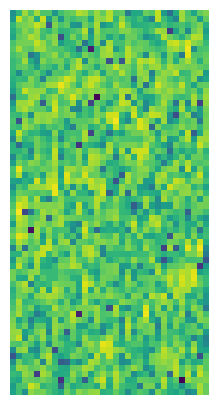

In [21]:
signal_path = '../data/RadioML/snr_-20db/train/128QAM/sample_0.npy'
signal = load_npy_file(signal_path)
signal_data = convert_signal_to_complex(signal)
colormap = 'viridis'  # Choose a colormap for visualization
eps = 1e-12
_,_, stft_matrix = stft(signal_data, nperseg=64, noverlap=32, window= 'hann', return_onesided=False)
stft_matrix = np.fft.fftshift(stft_matrix, axes=0) 

# Calculate power spectral density (magnitude squared)
spectrum: np.ndarray = np.abs(stft_matrix) ** 2
# Convert to dB for plotting
spectrum_db: np.ndarray = 10 * np.log10(spectrum + eps)

image = convert_to_pil(spectrum_db=spectrum_db, colormap=colormap)
# Display the image
print(f"Image size: {image.size}")
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image)
ax.axis('off')  # Hide axes
plt.show()

In [ ]:
image_paths, labels, class_to_idx, idx_to_class = load_image_data('../data/RadioML/snr_-20db/train/')
print(f"Found {len(image_paths)} images in {len(class_to_idx)} classes.")
print(f"path {image_paths[0]} with label {idx_to_class[labels[0]]}")